# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import time
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier


# Importing Dataset

In [3]:
df=pd.read_csv('Hotel_Reviews.csv')

# Data Exploration and some pre-processing

In [4]:
display(df.shape)

(515738, 17)

In [6]:
display(df.describe())

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,8.395077,49.442439,2.823803
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,1.637856,3.466325,4.579425
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,7.500000,48.214662,-0.143372
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,8.800000,51.499981,0.010607
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233


In [7]:
display(df.describe(include=['O']))

,Hotel_Address,Review_Date,Hotel_Name,Reviewer_Nationality,Negative_Review,Positive_Review,Tags,days_since_review
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2585,4789,245246,127890,35946,5101,2585


In [8]:
df.keys()

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [9]:
# create a database with only hotels info 
hotels=df[['Hotel_Name','Average_Score','Total_Number_of_Reviews',\
           'Hotel_Address', 'Additional_Number_of_Scoring','lat', 'lng']].drop_duplicates().reset_index()
print(hotels.shape)
hotels.head(3)

(1494, 8)


,index,Hotel_Name,Average_Score,Total_Number_of_Reviews,Hotel_Address,Additional_Number_of_Scoring,lat,lng
0,0,Hotel Arena,7.7,1403,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,52.360576,4.915968
1,405,K K Hotel George,8.5,1831,1 15 Templeton Place Earl s Court Kensington a...,244,51.491888,-0.194971
2,971,Apex Temple Court Hotel,9.2,2619,1 2 Serjeant s Inn Fleet Street City of London...,639,51.513734,-0.108751


playing aroung with the data to get confortable with it and get some new columns and lists that could be useful for better understanding of the dataset.

In [10]:
# Hotel address ---> Country ('Netherlands', 'UK', 'France', 'Spain', 'Italy', 'Austria')
hotels['Country']=hotels['Hotel_Address'].apply(lambda x: x.split()[-1]).replace('Kingdom','UK')
hotels.Country.unique()

array(['Netherlands', 'UK', 'France', 'Spain', 'Italy', 'Austria'],
      dtype=object)

In [11]:
# To see which country gives more reviews (UK most of the time)
# So lets get the most common nationality of reviews for each hotel
most_national=df[['Hotel_Name','Hotel_Address','Reviewer_Nationality']].groupby(['Hotel_Name','Hotel_Address']).agg(lambda x:x.value_counts().index[0])

In [12]:
# In case we want to use the Tags, here I clean up the format 
# and create list from Tags ranked them by occurence
tags_rank=pd.Series(re.findall(r'[\']\s([\w\s]+)\s[\']',''.join(df.Tags))).value_counts()

In [13]:
# Correct day of the review into integer
df['days_since_review']=pd.to_numeric(df['days_since_review'].str.replace(r'[a-z]+', ""))

In [14]:
# DataFrames with Negative reviews and positive reviews given
neg_rev=df[df.Negative_Review!='No Negative'].reset_index().drop('index',1)
pos_rev=df[df.Positive_Review!='No Positive'].reset_index().drop('index',1)
neg_rev = neg_rev[neg_rev['Reviewer_Score']<5].reset_index().drop('index',1)
pos_rev = pos_rev[pos_rev['Reviewer_Score']>8].reset_index().drop('index',1)


## Word Tokenization

In [15]:
# Takes review and gives back the clean list of words

#TokTok faster than word_tokenize
from nltk.tokenize import ToktokTokenizer
toktok = ToktokTokenizer()

# Stopwords, numbers and punctuation to remove
remove_punct_and_digits = dict([(ord(punct), ' ') for punct in string.punctuation + string.digits])
stopWords = set(stopwords.words('english'))


def word_cleaner(data):
    cleaned_word = data.lower().translate(remove_punct_and_digits)
    words = word_tokenize(cleaned_word)
    words = [toktok.tokenize(sent) for sent in sent_tokenize(cleaned_word)]
    wordsFiltered = []
    if not words:
        pass
    else:
        for w in words[0]:
            if w not in stopWords:
                wordsFiltered.append(w)
                end=time.time()
    return wordsFiltered


In [22]:
# Example
wordsFiltered = word_cleaner(neg_rev.Negative_Review[1])
print(neg_rev.Negative_Review[1])
print("-"*127)
print(wordsFiltered)

 My room was dirty and I was afraid to walk barefoot on the floor which looked as if it was not cleaned in weeks White furniture which looked nice in pictures was dirty too and the door looked like it was attacked by an angry dog My shower drain was clogged and the staff did not respond to my request to clean it On a day with heavy rainfall a pretty common occurrence in Amsterdam the roof in my room was leaking luckily not on the bed you could also see signs of earlier water damage I also saw insects running on the floor Overall the second floor of the property looked dirty and badly kept On top of all of this a repairman who came to fix something in a room next door at midnight was very noisy as were many of the guests I understand the challenges of running a hotel in an old building but this negligence is inconsistent with prices demanded by the hotel On the last night after I complained about water damage the night shift manager offered to move me to a different room but that offer 

In [23]:
# We take a small sample within our database to speed up Learning
# with a decent machine and some time to spare we can easily skip this step
neg_red=neg_rev[:50000].copy()
pos_red=pos_rev[:50000].copy()

# Data preparation and Model Building

In [24]:
# Create set related to positive and negative review
def word_feats(words):
    return dict([(word, True) for word in words])
neg_set=[(word_feats(word_feats(word_cleaner(neg_red.loc[i,'Negative_Review']))), 0) for i in range(len(neg_red))]
pos_set=[(word_feats(word_feats(word_cleaner(pos_red.loc[i,'Positive_Review']))), 1) for i in range(len(pos_red))]

In [25]:
# Spliting the data into train and test set

negcutoff = int(len(neg_set)*3/4)
poscutoff = int(len(pos_set)*3/4)
 
trainfeats = neg_set[:negcutoff] + pos_set[:poscutoff]
testfeats = neg_set[negcutoff:] + pos_set[poscutoff:]
print(len(trainfeats), len(testfeats))

53724 17908


### Building the Naive Bayes Classifire and checking its accuracy

In [26]:
classifier = NaiveBayesClassifier.train(trainfeats)
print( 'accuracy:', nltk.classify.util.accuracy(classifier, testfeats))

accuracy: 0.8930645521554612


# Scoring words based on it's sentiment

In [27]:
# Now we want to have a clear overview of the most hated/loved words so...
# Builds the dataframe of words with respective sentiment and score

cpdist = classifier._feature_probdist
word=[]
score=[]
sentiment=[]
for (fname, fval) in classifier.most_informative_features(100):
            def labelprob(l):
                return cpdist[l, fname].prob(fval)

            labels = sorted([l for l in classifier._labels
                             if fval in cpdist[l, fname].samples()],
                            key=labelprob)
            if len(labels) == 1:
                continue
            l0 = labels[0]
            l1 = labels[-1]
            if cpdist[l0, fname].prob(fval) == 0:
                ratio = 'INF'
            else:
                ratio = '%8.1f' % (cpdist[l1, fname].prob(fval) /
                                   cpdist[l0, fname].prob(fval))
            sentiment.append(int(l1))
            word.append(fname)
            score.append(float(ratio))

In [28]:
# Divides scores into negative and positive
word_scores=pd.DataFrame({'word':word,'sentiment':sentiment,'score':score})
neg_word_scores=word_scores[word_scores.sentiment==0]
pos_word_scores=word_scores[word_scores.sentiment==1]
display(word_scores[word_scores['sentiment']==1].head())
display(word_scores[word_scores['sentiment']==0].head())
neg_given=df[df.Negative_Review!='No Negative'].reset_index().drop('index',1)
pos_given=df[df.Positive_Review!='No Positive'].reset_index().drop('index',1)

,word,sentiment,score
7,superb,1,198.0
20,delicious,1,127.1
47,excellent,1,77.8
54,fab,1,72.0
56,beautifully,1,70.8


,word,sentiment,score
0,worst,0,929.9
1,rude,0,691.1
2,dirty,0,648.6
3,disgusting,0,361.3
4,terrible,0,302.3


In [29]:
# I want to create two new columns, one that will give a positive and one a negative score
# Sums positive and negative scores for a given review
def pos_sentiment_sum(review):
    pos=0
    asd=word_cleaner(review)
    set_w=set(pos_word_scores.word)-set(['no','negative','positive'])
    
    for word in asd:
        if word in set_w:
            pos+=pos_word_scores[pos_word_scores['word']==word].score.iloc[0]
    
    return pos

def neg_sentiment_sum(review):
    neg=0
    asd=word_cleaner(review)
    set_w=set(neg_word_scores.word)-set(['no','negative','positive'])
    
    for word in asd:
        if word in set_w:
            neg+=neg_word_scores[neg_word_scores['word']==word].score.iloc[0]
    

In [30]:
# TEST
print('negative score:',neg_sentiment_sum(df.Negative_Review[6584]),\
       'positive score:', pos_sentiment_sum(df.Positive_Review[6584]))

negative score: None positive score: 77.8


In [31]:
# I comment it out so it does not need to run when I submit

# This is the final step where we get the additional columns 
# Produce the pos and neg colums in database

#=================
pos_col=[]
for i in range(len(df)):
    if df.Positive_Review[i]=='No Positive':
        pos_col.append(int(0))
    else:
        pos_col.append(pos_sentiment_sum(df.Positive_Review[i]))
df['pos_score']=pos_col

neg_col=[]
for i in range(len(df)):
    if df.Negative_Review[i]=='No Negative':
        neg_col.append(int(0))
    else:
        neg_col.append(neg_sentiment_sum(df.Negative_Review[i]))
df['neg_score']=neg_col
#=================

In [32]:
# Reviews grouped by rate band
score_9=df[df.Reviewer_Score>9].copy()
score_4=df[df.Reviewer_Score<4].copy()
score_6=df[df.Reviewer_Score<7].copy()
score_7=df[(df.Reviewer_Score>7)&(df.Reviewer_Score<8)].copy()
score_8=df[(df.Reviewer_Score>8)&(df.Reviewer_Score<9)].copy()
print(score_6.shape)
print(score_7.shape)
print(score_8.shape)
print(score_9.shape)

(86851, 19)
(92830, 19)
(88104, 19)
(246390, 19)


# Some Data Visualization

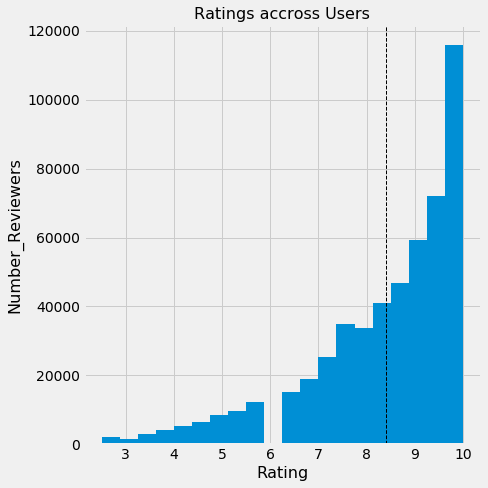

In [33]:
# Some plots

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.style.use('fivethirtyeight')

plt.figure(figsize=(7,7))
plt.hist(df['Reviewer_Score'],bins=20)
plt.ylabel('Number_Reviewers',fontsize=16)
plt.xlabel('Rating',fontsize=16)
plt.title('Ratings accross Users',fontsize=16)
plt.axvline(df['Reviewer_Score'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_user.png')

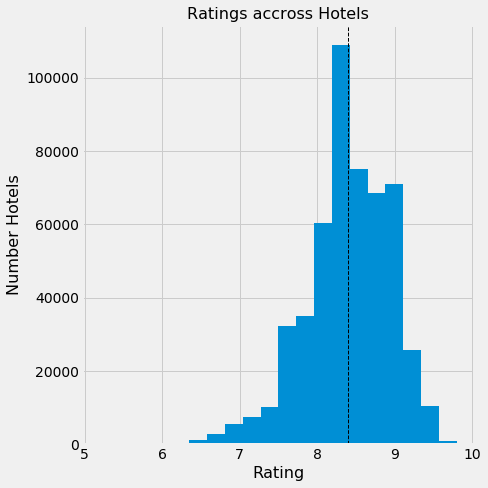

In [34]:
plt.figure(figsize=(7,7))
plt.hist(df['Average_Score'],bins=20)
plt.ylabel('Number Hotels',fontsize=16)
plt.xlabel('Rating',fontsize=16)
plt.title('Ratings accross Hotels',fontsize=16)
plt.axvline(df['Average_Score'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_hotel.png')


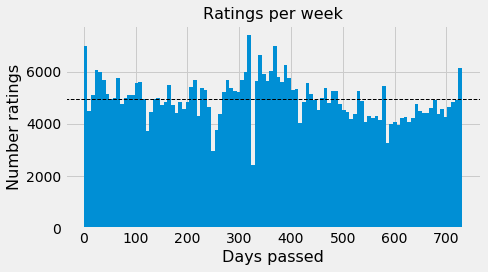

In [35]:
plt.figure(figsize=(7,4))
week_bins=int(np.floor((max(df['days_since_review'])-min(df['days_since_review']))/7))
vals = plt.hist(df['days_since_review'],bins=week_bins);
plt.ylabel('Number ratings',fontsize=16)
plt.xlabel('Days passed',fontsize=16)
plt.title('Ratings per week',fontsize=16)
plt.axhline(vals[0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_week.png')

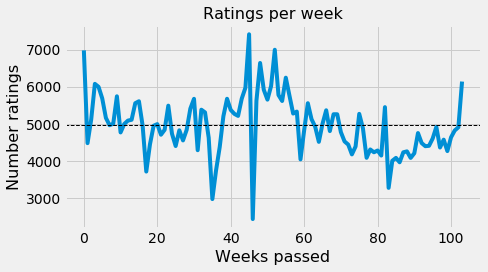

In [36]:
plt.figure(figsize=(7,4))
plt.plot(vals[0]);
plt.ylabel('Number ratings',fontsize=16)
plt.xlabel('Weeks passed',fontsize=16)
plt.title('Ratings per week',fontsize=16)
plt.axhline(vals[0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_week_plot.png')